In [77]:
import keras
import numpy as np
import tensorflow as tf
from keras.datasets import mnist
from matplotlib import pyplot as plt

In [78]:
(x_train, labels_train), (x_test, labels_test) = mnist.load_data()

In [79]:
x_train = np.concatenate((x_train, x_test), axis=0)
labels_train = np.concatenate((labels_train, labels_test), axis=0)

In [80]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train.shape

(70000, 28, 28)

# Reshape the data to fit the model

In [81]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# One-hot encoding

In [82]:
from keras.utils import to_categorical
y_train = to_categorical(labels_train, 10)
y_test = to_categorical(labels_test, 10)

# Data augmentation

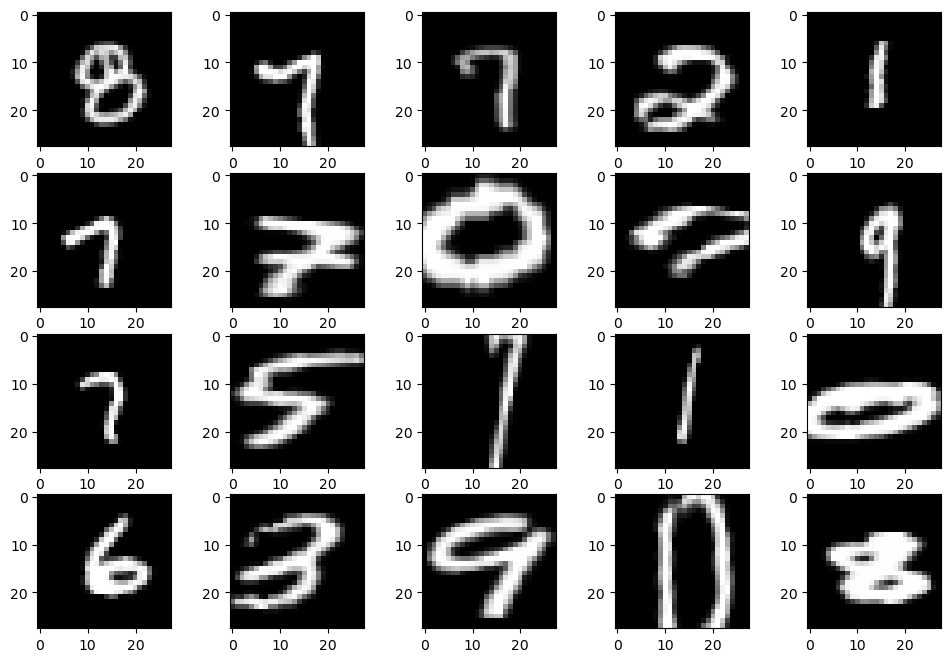

In [83]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    zoom_range=0.5,
    shear_range=0.2,
    fill_mode='nearest')

#Plots our figures
pic = datagen.flow(x_train, batch_size=1024)
plt.figure(figsize=(12,8))
for i in range(1,21):
  plt.subplot(4, 5, i)
  batch = pic.next()
  image_ = batch[0].astype('float32')
  plt.imshow(image_, cmap='gray')
plt.show()

# Define the CNN model

In [84]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())


model.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_35 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_18 (Bat  (None, 14, 14, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_36 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 conv2d_37 (Conv2D)          (None, 14, 14, 64)       

# K-fold cross-validation

In [85]:
# Train and evaluate the model with k-fold cross-validation
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping

historys = []

batch_size = 2048
epochs = 10
n_splits = 10

kfold = KFold(n_splits=n_splits, shuffle=True)

for fold, (train_indices, val_indices) in enumerate(kfold.split(x_train)):
    print('Fold:', fold+1)
    x_train_fold = x_train[train_indices]
    y_train_fold = y_train[train_indices]
    x_val_fold = x_train[val_indices]
    y_val_fold = y_train[val_indices]
    
    # Fit the model with data augmentation
    history = model.fit(datagen.flow(x_train_fold, y_train_fold, batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_val_fold, y_val_fold),
                        callbacks=[EarlyStopping(patience=5)])
    
    historys.append(history)

Fold: 1
Epoch 1/10


2023-02-21 19:46:09.066472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 1.1241 - accuracy: 0.6474

2023-02-21 19:46:17.425947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 11s 337ms/step - loss: 1.1241 - accuracy: 0.6474 - val_loss: 2.1922 - val_accuracy: 0.1166
Epoch 2/10
31/31 [==============================] - 9s 295ms/step - loss: 0.3406 - accuracy: 0.8951 - val_loss: 2.3730 - val_accuracy: 0.1166
Epoch 3/10
31/31 [==============================] - 9s 296ms/step - loss: 0.2200 - accuracy: 0.9334 - val_loss: 2.7819 - val_accuracy: 0.1166
Epoch 4/10
31/31 [==============================] - 10s 309ms/step - loss: 0.1720 - accuracy: 0.9486 - val_loss: 3.6384 - val_accuracy: 0.1166
Epoch 5/10
31/31 [==============================] - 9s 294ms/step - loss: 0.1439 - accuracy: 0.9563 - val_loss: 4.2654 - val_accuracy: 0.1166
Epoch 6/10
31/31 [==============================] - 9s 292ms/step - loss: 0.1275 - accuracy: 0.9611 - val_loss: 4.4535 - val_accuracy: 0.1166
Fold: 2
Epoch 1/10
31/31 [==============================] - 9s 299ms/step - loss: 0.1110 - accuracy: 0.9663 - val_loss: 4.7505 - val_accuracy: 0.1106
Epoch 2

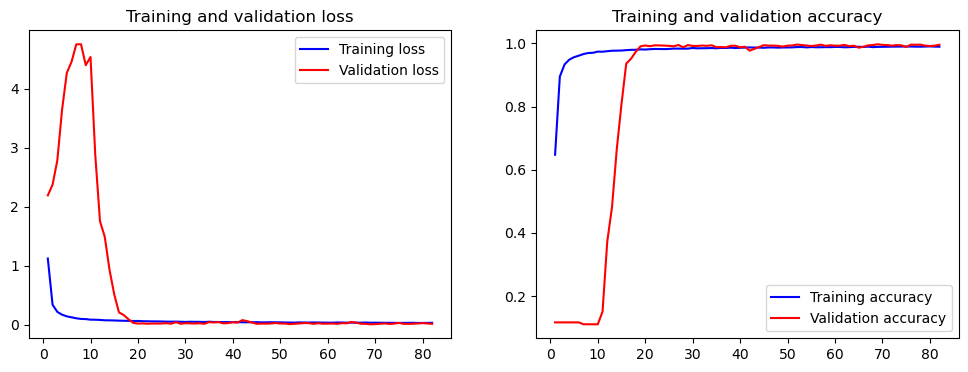

In [86]:
losses = [loss for history in historys for loss in history.history['loss']]
val_losses = [val_loss for history in historys for val_loss in history.history['val_loss']]
accuracies = [accuracy for history in historys for accuracy in history.history['accuracy']]
val_accuracies = [val_accuracy for history in historys for val_accuracy in history.history['val_accuracy']]

epochs = range(1, len(losses) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()
    

In [87]:
model.save("network_for_mnist.h5")